# ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS EN XGBOOST

Al igual que ocurre con los Bosques Aleatorios, los modelos XGBoost son explicables mas no interpretables.

A pesar de esto, XGBoost (también al igual que ocurre con los Bosques Aleatorios), permite realizar el cálculo de la importancia de las características que cuantifica el impacto que cada característica tiene en las predicciones, lo que facilita la explicabilidad del modelo.

En XGBoost esta importancia de las características se puede calcular de tres formas:

- *weight*: cuantifica el número de veces que una característica es usada para generar particiones.
- *cover*: cuantifica el número promedio de datos que son afectados por una característica al generar una partición
- *gain* o *total_gain*: cuantifica la ganancia promedio o la ganancia total generada por una característica dentro del modelo

Realmente, la importancia **gain** es la que más nos interesa, pues realmente mide la calidad de las particiones generada por cada característica.

Veamos cómo realizar este análisis de importancia de características para los modelos afinados tanto de clasificación como de regresión obtenidos anteriormente.

## 1. Análisis de importancia de características para el modelo de clasificación

Comencemos leyendo el set de datos y generando la partición en entrenamiento y prueba:

In [1]:
# Leer dataset
import pandas as pd
from sklearn.model_selection import train_test_split

RUTA = '/Users/miguel/Library/CloudStorage/GoogleDrive-miguel@codificandobits.com/My Drive/02-CODIFICANDOBITS.COM/04-Academia/01-Cursos/30-2024-12-XGBoost/data/'
df = pd.read_csv(RUTA + 'dataset_prestamos_clasif.csv')

# Representar las variables categóricas como tipo "category"
# (género, educación, propietario, prestamo_uso, impagos previos)
cols_cat = df.select_dtypes(include='object').columns
for col in cols_cat:
    df[col] = df[col].astype("category")

df.info()

# Crear sets X y Y y partir dataset
X = df.iloc[:,:-1] # Características (variables predictoras)
Y = df.iloc[:,-1] # Variable a predecir

# Crear sets de entrenamiento y prueba (la validación se tomará del set de entrenamiento)
x_tr, x_ts, y_tr, y_ts = train_test_split(X, Y, train_size=0.8, random_state=123)

print('Tamaño set de entrenamiento: ' , x_tr.shape, y_tr.shape)
print('Tamaño set de prueba: ', x_ts.shape, y_ts.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19638 entries, 0 to 19637
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   edad                        19638 non-null  float64 
 1   genero                      19638 non-null  category
 2   educacion                   19638 non-null  category
 3   ingresos                    19638 non-null  float64 
 4   annos_exp_laboral           19638 non-null  int64   
 5   propietario                 19638 non-null  category
 6   prestamo_monto_solicitado   19638 non-null  float64 
 7   prestamo_uso                19638 non-null  category
 8   prestamo_tasa               19638 non-null  float64 
 9   prestamo_pctj_ing           19638 non-null  float64 
 10  annos_historial_crediticio  19638 non-null  float64 
 11  ptj_crediticio              19638 non-null  int64   
 12  impagos_previos             19638 non-null  category
 13  estado_prestamo 

Ahora entrenaremos el modelo con los mejores hiper-parámetros obtenidos durante la afinación:

In [2]:
from xgboost import XGBClassifier

# Hiper-parámetros que no se afinaron
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'random_state': 42,   
    'n_jobs': -1
}

# Conjunto total de parámetros
best_params = {'colsample_bytree': 0.7, 'eta': 0.4, 'gamma': 0.2, 'lambda': 2, 'max_depth': 4}
parametros = params | best_params | {'enable_categorical':True}
clf_afinado = XGBClassifier(**parametros)
clf_afinado.fit(x_tr,y_tr)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.4, eval_metric=None,
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=2,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, ...)

Con el modelo entrenado es muy sencillo acceder a la importancia de características (calculada automáticamente tras el entrenamiento). Simplemente usamos el método "get_score()":

In [6]:
# Diferentes maneras de calcular feature importances
clf_afinado.get_booster().get_score(importance_type='gain')
# clf_afinado.get_booster().get_score(importance_type='cover')
# clf_afinado.get_booster().get_score(importance_type='weight')

{'edad': 3.1946911811828613,
 'genero': 3.472308874130249,
 'educacion': 2.2046608924865723,
 'ingresos': 13.525074005126953,
 'annos_exp_laboral': 2.2486801147460938,
 'propietario': 40.43974685668945,
 'prestamo_monto_solicitado': 3.465599298477173,
 'prestamo_uso': 10.962438583374023,
 'prestamo_tasa': 28.78606414794922,
 'prestamo_pctj_ing': 46.63093185424805,
 'annos_historial_crediticio': 2.322892189025879,
 'ptj_crediticio': 4.775864601135254,
 'impagos_previos': 366.567138671875}

XGBoost incorpora la función "plot_importance" que con muy pocas líneas de código permite realizar el gráfico de importancia de características:

<Axes: title={'center': 'Importancia de características (ganancia)'}, xlabel='Ganancia promedio', ylabel='Característica'>

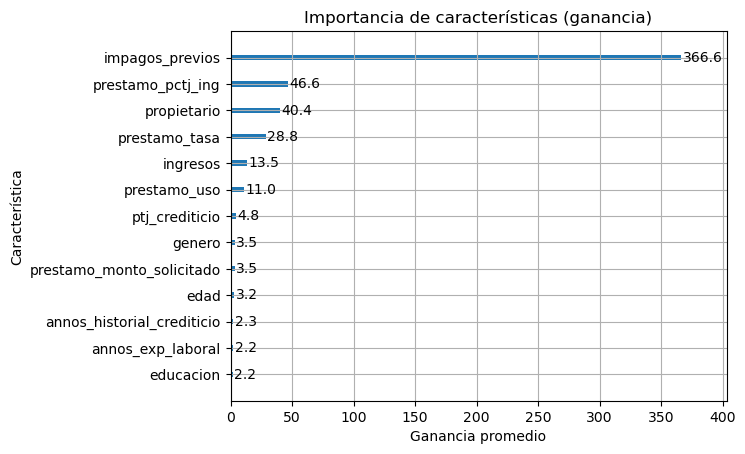

In [7]:
# Graficar la importancia de las características
from xgboost import plot_importance
plot_importance(clf_afinado, importance_type='gain',
                title = 'Importancia de características (ganancia)',
                xlabel = 'Ganancia promedio', ylabel = 'Característica',
                values_format = '{v:.1f}')


Pero en ocasiones es mejor normalizar estas características (con respecto a la ganancia promedio total) y luego generar el gráfico correspondiente.

Creemos una función para generar esta gráfica:

In [8]:
import seaborn as sns

def graficar_importancias(modelo):

    # Convertir diccionario de importancias a DataFrame de Pandas
    data = modelo.get_booster().get_score(importance_type='gain')
    df = pd.DataFrame(data.items(), columns=['característica', 'importancia']).sort_values(by='importancia', ascending=False)

    # Normalizar DataFrame
    total = df['importancia'].sum()
    df['importancia'] = 100*df['importancia']/total
    df['importancia'] = df['importancia'].round(2)

    # Generar gráfico
    ax = sns.barplot(data=df, y='característica', x='importancia')
    ax.grid()

    # Mostrar el porcentaje asociado a cada barra
    for i in ax.containers:
        ax.bar_label(i)

Y ahora simplemente ejecutemos la función anterior sobre el modelo afinado:

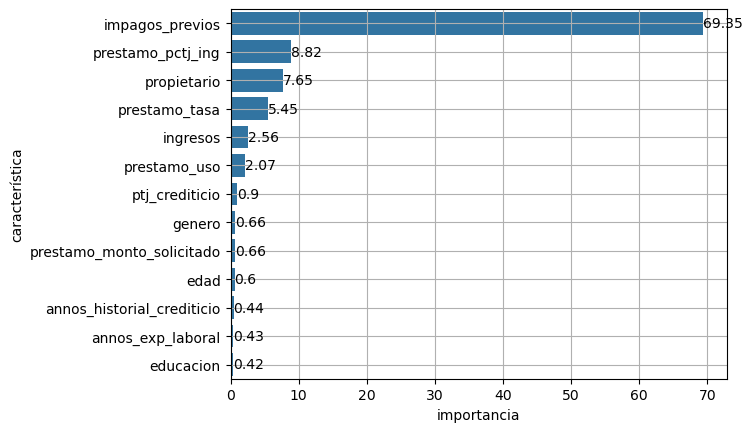

In [9]:
graficar_importancias(clf_afinado)

Y acá podemos concluir que "impagos_previos" es la característica que tiene un mayor peso (cercano al 70%) en las predicciones, seguida por "prestamo_pctj_ing", "propietario" y "prestamo_tasa" que suman casi el 22% de la importancia de las características.

## 2. Análisis de importancia de características para el modelo de regresión

Y repitamos el mismo procedimiento anterior pero para el modelo de regresión afinado, obtenido en la lección anterior.

Comencemos leyendo el set de datos y generando la partición en entrenamiento y prueba:

In [10]:
# Leer dataset
import pandas as pd
from sklearn.model_selection import train_test_split

RUTA = '/Users/miguel/Library/CloudStorage/GoogleDrive-miguel@codificandobits.com/My Drive/02-CODIFICANDOBITS.COM/04-Academia/01-Cursos/30-2024-12-XGBoost/data/'
df = pd.read_csv(RUTA + 'dataset_prestamos_regr.csv')

# Representar las variables categóricas como tipo "category"
# (género, educación, propietario, prestamo_uso, impagos previos)
cols_cat = df.select_dtypes(include='object').columns
for col in cols_cat:
    df[col] = df[col].astype("category")

df.info()

# Crear sets X y Y y partir dataset
X = df.iloc[:,:-1] # Características (variables predictoras)
Y = df.iloc[:,-1] # Variable a predecir

# Crear sets de entrenamiento y prueba (la validación se tomará del set de entrenamiento)
x_tr, x_ts, y_tr, y_ts = train_test_split(X, Y, train_size=0.8, random_state=123)

print('Tamaño set de entrenamiento: ' , x_tr.shape, y_tr.shape)
print('Tamaño set de prueba: ', x_ts.shape, y_ts.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9819 entries, 0 to 9818
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   edad                        9819 non-null   float64 
 1   genero                      9819 non-null   category
 2   educacion                   9819 non-null   category
 3   ingresos                    9819 non-null   float64 
 4   annos_exp_laboral           9819 non-null   int64   
 5   propietario                 9819 non-null   category
 6   prestamo_monto_solicitado   9819 non-null   float64 
 7   prestamo_uso                9819 non-null   category
 8   prestamo_pctj_ing           9819 non-null   float64 
 9   annos_historial_crediticio  9819 non-null   float64 
 10  ptj_crediticio              9819 non-null   int64   
 11  prestamo_tasa               9819 non-null   float64 
dtypes: category(4), float64(6), int64(2)
memory usage: 652.8 KB
Tamaño set de en

In [11]:
from xgboost import XGBRegressor

# Hiper-parámetros que no se afinaron
params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'random_state': 42,   
    'n_jobs': -1
}

# Conjunto total de parámetros
best_params = {'colsample_bytree': 0.8, 'eta': 0.1, 'gamma': 0, 'lambda': 0, 'max_depth': 6}
parametros = params | best_params | {'enable_categorical':True}
reg_afinado = XGBRegressor(**parametros)
reg_afinado.fit(x_tr,y_tr)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=True, eta=0.1, eval_metric=None,
             feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None, lambda=0,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, ...)

Y a hora simplemente usamos la función "graficar_importancias()" creada anteriormente:

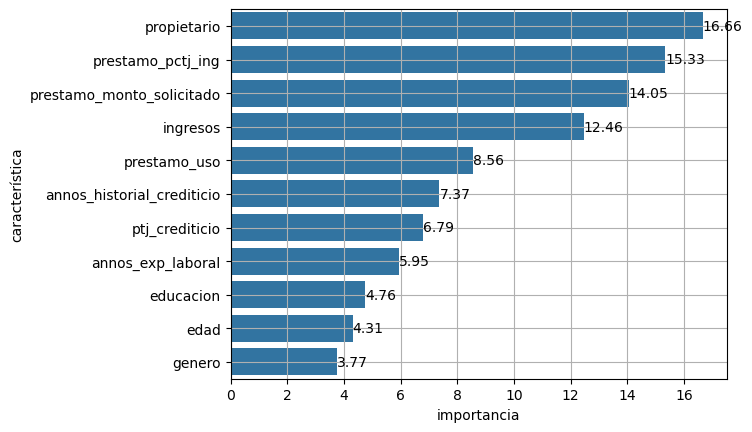

In [12]:
graficar_importancias(reg_afinado)

Y en este caso vemos que "prestamo_pct_ing" e "ingresos" representan aproximadamente el 46% de la importancia de las características, seguidas por "prestamo_monto_solicitado", "propietario" y "prestamo_uso" que sumadas representan casi el 36%.